## Petrophysical properties inversion from seismic data

In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
from random import randint
from wiggle.wiggle import wiggle
from matplotlib.pyplot import figure
import math
import tensorflow as tf
from scipy.interpolate import interp1d
import scipy.signal as sp

In [2]:
# Checking the devices available for use in AWS
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14218417434729025764
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5141893544539571779
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16337833686694234708
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11326753997
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8711439471532368772
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


In [3]:
# Loading the Vp, Vs and Density data

dataframe = np.load('../../../Data_Stybarrow_field/training_data_based_on_sty2.npz')
# Vp = dataframe['vp']
# Vp = np.reshape(Vp, (Vp.shape[0]*Vp.shape[1], Vp.shape[2]))
# Vs = dataframe['vs']
# Vs = np.reshape(Vs, (Vs.shape[0]*Vs.shape[1], Vs.shape[2]))
# RHOB = dataframe['rhob']
# RHOB = np.reshape(RHOB, (RHOB.shape[0]*RHOB.shape[1], RHOB.shape[2]))

depth = dataframe['depth']

# # Loading porosity, vclay 
# dataframe_facies = sio.loadmat('../../../Data_generation_base_case/Train_FaciesMat.mat')
# facies = dataframe_facies['zFaciesMat']
# facies = np.reshape(facies, (facies.shape[0]*facies.shape[1], facies.shape[2]))

# dataframe_porosity = sio.loadmat('../../../Data_generation_base_case/Train_PhiMat.mat')
porosity = dataframe['poro']
# porosity = np.reshape(porosity, (porosity.shape[0]*porosity.shape[1], porosity.shape[2]))

# dataframe_vclay = sio.loadmat('../../../Data_generation_base_case/Train_ClayMat.mat')
vclay = dataframe['vshale']
# vclay = np.reshape(vclay, (vclay.shape[0]*vclay.shape[1], vclay.shape[2]))

# dataframe_Sw = sio.loadmat('../../../Data_generation_base_case/Train_SwMat.mat')
# Sw = dataframe_Sw['zSwMat']
# Sw = np.reshape(Sw, (Sw.shape[0]*Sw.shape[1], Sw.shape[2]))

# vclay_final = dataframe['vshale_final']


In [4]:
# AVO and source parameters 
src_len=np.int(60)
freq=35
dt=3e-3
# ntheta=46
thetaStart=0
thetaEnd=30
thetaInc=30
theta=np.arange(thetaStart,thetaEnd+thetaInc,thetaInc)
ntheta=theta.size
# nt=201
# ncdp=1111
angle=np.reshape(theta,[1,ntheta])
# theta=np.arange(0,ntheta,1)
print('angle:', angle.shape)
print('angle:', angle)

angle: (1, 2)
angle: [[ 0 30]]


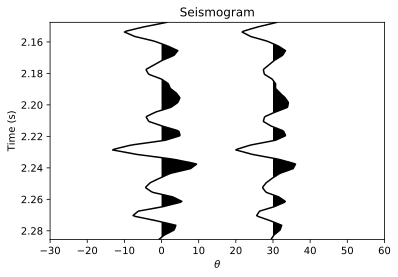

In [5]:
# Load forward modeled seismic data and Rpp
# seis = np.load('../../../Data_generation_base_case/seismic_forward_modeled.npy')
seis = dataframe['seis']
time_upscaled = dataframe['time_seis']
# Rpp = np.load('../../../Data_generation_base_case/Rpp_forward_modeled.npy')

sample_number = 12
wiggle(np.squeeze(seis[sample_number,:,:]),time_upscaled,theta)
plt.title("Seismogram")
plt.xlabel("$\\theta$")
plt.ylabel("Time (s)")
plt.show()

# impedance_time = Vp_time * RHOB_time
# impedance_time_sample = impedance_time[sample_number,:]
# plt.subplot(1,3,1)
# plt.plot((impedance_time_sample - np.min(impedance_time_sample))/(np.max(impedance_time_sample)-np.min(impedance_time_sample)), time_upscaled)
# plt.gca().invert_yaxis()
# plt.subplot(1,3,2)
# seis_sample = np.squeeze(seis[sample_number,:,0])
# plt.plot((seis_sample - np.min(seis_sample))/(np.max(seis_sample) - np.min(seis_sample)), time_upscaled)
# plt.gca().invert_yaxis()
# plt.subplot(1,3,3)
# # plt.plot(np.squeeze(Rpp[sample_number,:,0]), time_upscaled)
# plt.gca().invert_yaxis()

<Figure size 720x720 with 0 Axes>

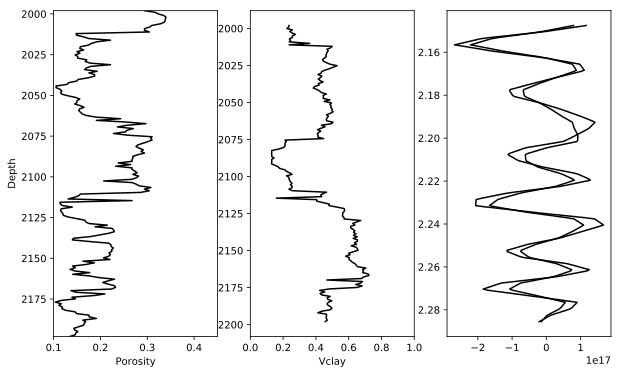

In [6]:
# Plot of loaded data

plt.figure(figsize=(10,10))

sample_number = 20
f, axarr = plt.subplots(1, 3, sharey = False, figsize=(10,6))

axarr[0].plot(porosity[sample_number, :], depth, color = "black")
axarr[0].set_xlabel("Porosity")
axarr[0].set_ylabel("Depth")
axarr[0].set_ylim([np.min(depth),np.max(depth)])
axarr[0].set_xlim(0.1,0.45)
axarr[0].invert_yaxis()

axarr[1].plot(vclay[sample_number, :], depth, color = "black")
# axarr[1].plot(vclay_final[sample_number, :], depth, color = "red")
axarr[1].set_xlabel("Vclay")
axarr[1].invert_yaxis()
axarr[1].set_xlim(0,1)

axarr[2].plot(np.squeeze(seis[sample_number,:,:]),time_upscaled, color = "black")
axarr[2].invert_yaxis()
# axarr[2].set_xlabel("Vp")
# # axarr[2].set_xlim(0,1)

# axarr[3].plot(Vs[sample_number, :], depth, color = "black")
# axarr[3].set_xlabel("Vs")
# # axarr[3].set_xlim(0,1)



In [7]:
# Import keras modules for CNN

from keras import layers, initializers, optimizers
from keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling1D, MaxPooling2D, Dropout, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import LeakyReLU, Reshape
from keras.models import Model, model_from_json, load_model
from keras.preprocessing import image
from keras.utils import layer_utils, normalize
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.utils import np_utils, normalize
from keras.backend import manual_variable_initialization
from keras.callbacks import EarlyStopping, ModelCheckpoint

# from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')

import sklearn.model_selection
import pydot
import random

Using TensorFlow backend.


In [94]:
# Getting the input data (normalized) and output data 

# # Cropping data to zone of interest
# depth_top = 2051
# depth_bottom = 2250
# indx_depth = np.where((depth>=depth_top) & (depth<=depth_bottom))
# porosity = np.reshape(porosity[:,indx_depth], (porosity.shape[0], np.shape(indx_depth)[1]))
# vclay = np.reshape(vclay[:,indx_depth], (vclay.shape[0], np.shape(indx_depth)[1]))
# depth_new = depth[indx_depth]

# time_top = 1974/1e3
# time_bottom = 2130/1e3
# indx_time = np.where((time_upscaled>=time_top) & (time_upscaled<=time_bottom))
# time_new = np.linspace(np.min(time_upscaled[indx_time]), np.max(time_upscaled[indx_time]), 246)
# seis = np.swapaxes(interp1d(time_upscaled, np.swapaxes(seis,1,2))(time_new),1,2)


# Reshape seismic gathers into (number of examples, angle, time) and normalize such that seismic traces have positive values
seis_reshaped = np.swapaxes(seis,1,2)
# seis_reshaped_normalized = (seis_reshaped - np.min(seis_reshaped))/(np.max(seis_reshaped)-np.min(seis_reshaped))
seis_test = np.reshape(seis_reshaped, (seis_reshaped.shape[0]*seis_reshaped.shape[1], seis_reshaped.shape[2]))
seis_reshaped_normalized = np.transpose(
    (seis_test.T - np.min(seis_test, axis=1))/(np.max(seis_test, axis=1) - np.min(seis_test, axis=1)))
seis_reshaped_normalized = np.reshape(seis_reshaped_normalized, (seis_reshaped.shape[0], seis_reshaped.shape[1], seis_reshaped.shape[2]))


# Selecting near(0 degree) and far (30 degree) angle traces from the full seismic gathers
row_idx = np.array([0, 1])
angle_seis_reshaped_normalized = seis_reshaped_normalized[:,row_idx,:]

# Concatenate Porosity, Vclay, Sw 
num_examples = porosity.shape[0]
ndepth = porosity.shape[1]

# Normalize porosity
porosity_norm = (porosity - np.min(porosity))/(np.max(porosity) - np.min(porosity))
vclay_norm = (vclay - np.min(vclay))/(np.max(vclay) - np.min(vclay))
# porosity_norm = np.transpose(
#     (porosity.T- np.min(porosity, axis=1))/(np.max(porosity, axis=1) - np.min(porosity,axis=1)))

# petromodel = np.concatenate((porosity_norm,vclay,Sw), axis=1)
# petromodel = petromodel.reshape((num_examples, 3, ndepth))
petromodel = np.concatenate((porosity_norm,vclay), axis=1)
petromodel = petromodel.reshape((num_examples, 2, ndepth))


# petromodel_unnorm = np.concatenate((porosity,vclay), axis=1)
# petromodel_unnorm = petromodel_unnorm.reshape((num_examples, 2, ndepth))

# Split data into train and test set - petro model
# _, _, Y_train_petro, Y_test_petro = sklearn.model_selection.train_test_split(angle_seis_reshaped_normalized, 
#                                                                             petromodel_unnorm, test_size=0.2, random_state=1)


X_train_petro, X_test_petro, Y_train_petro_norm, Y_test_petro_norm = sklearn.model_selection.train_test_split(angle_seis_reshaped_normalized, 
                                                                            petromodel, test_size=0.2, random_state=1)

# Add 4th dimension of number of channels=1 to the input data
X_train_petro = np.expand_dims(X_train_petro, axis=3)
X_test_petro = np.expand_dims(X_test_petro, axis=3)

# # Add sty1 data into training set
# X_train_petro = np.concatenate((X_train_petro , angle_seis_sty1_normalized), axis=0)
# temp = np.concatenate((np.expand_dims(sty1_poro_block, axis=-1), np.expand_dims(sty1_vsh_block, axis=-1)), axis=1)
# Y_train_petro_norm = np.concatenate((Y_train_petro_norm, np.expand_dims((temp.T), axis=0)), axis=0)

# # Selecting 2000 samples for training and 500 samples for testing
# seed_number = 3
# random.seed(seed_number)
# train_samples = random.sample(range(0,X_train_petro.shape[0]), 2000)
# test_samples = random.sample(range(0, X_test_petro.shape[0]), 500)
# X_train_petro = X_train_petro[train_samples, :,:,:]
# Y_train_petro_norm = Y_train_petro_norm[train_samples, :,:]
# X_test_petro = X_test_petro[test_samples,:,:,:]
# Y_test_petro_norm = Y_test_petro_norm[test_samples,:,:]

# Y_train_petro = Y_train_petro[train_samples, :,:]
# Y_test_petro = Y_test_petro[test_samples,:,:]

print ("number of training examples petromodel = " + str(X_train_petro.shape[0]))
# print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples petromodel = " + str(X_test_petro.shape[0]))
print ("X_train_petromodel shape: " + str(X_train_petro.shape))
print ("Y_train_petromodel shape: " + str(Y_train_petro_norm.shape))
# print ("X_val shape: " + str(X_val.shape))
# print ("Y_val shape: " + str(Y_val.shape))
print ("X_test_petromodel shape: " + str(X_test_petro.shape))
print ("Y_test_petromodel shape: " + str(Y_test_petro_norm.shape))

number of training examples petromodel = 1747
number of test examples petromodel = 437
X_train_petromodel shape: (1747, 2, 246, 1)
Y_train_petromodel shape: (1747, 2, 200)
X_test_petromodel shape: (437, 2, 246, 1)
Y_test_petromodel shape: (437, 2, 200)


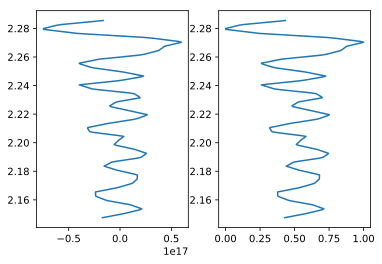

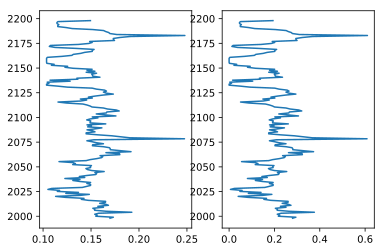

In [95]:
plt.subplot(1,2,1)
plt.plot(np.squeeze(seis_reshaped[2,1,:]),time_upscaled)
plt.subplot(1,2,2)
plt.plot(np.squeeze(seis_reshaped_normalized[2,1,:]),time_upscaled)
plt.show()

plt.subplot(1,2,1)
plt.plot(np.squeeze(porosity[2,:]),depth)
plt.subplot(1,2,2)
plt.plot(np.squeeze(porosity_norm[2,:]),depth)
plt.show()


In [96]:
# Building neural network for petrophysical properties prediction in Keras 
given_seed = 3 # For repeatibility


def petronet(input_shape):
    """
    Implementation of the PetroNet.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    

    # Define the input placeholder as a tensor with shape input_shape. Input = input angle gather 
    X_input = Input(input_shape)

    X = X_input

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(64, (2, 7), strides=(1, 2), name='conv0', padding='same',
               kernel_initializer=initializers.glorot_uniform(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn0')(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.3, name='drop_conv0')(X)
    # MAXPOOL
#     X = MaxPooling2D((1, 2), strides=(1,2),name='max_pool0')(X)
    
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (2, 15), strides=(1, 2), name='conv1',padding='same',
               kernel_initializer=initializers.glorot_uniform(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn1')(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.3, name='drop_conv1')(X)
    # MAXPOOL
#     X = MaxPooling2D((1, 2), strides=(1,2),name='max_pool1')(X)
    
    
#     # CONV -> BN -> RELU Block applied to X
    X = Conv2D(16, (1, 30), strides=(1, 2), name='conv2',padding='same',
               kernel_initializer=initializers.glorot_uniform(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn2')(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.3, name='drop_conv2')(X)
#     # MAXPOOL
#     X = MaxPooling2D((1, 2), strides=(1,2),name='max_pool2')(X)
    
    
#     # CONV -> BN -> RELU Block applied to X
    X = Conv2D(8, (1, 60), strides=(1, 2), name='conv3',padding='same',
               kernel_initializer=initializers.glorot_uniform(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn3')(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.3, name='drop_conv3')(X)
#     # MAXPOOL
#     X = MaxPooling2D((1, 2), strides=(1,2),name='max_pool3')(X)
    

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    
    # Considering Sw first dimension is 3, without first dimension is 2
    X = Dense(200*2, name='fc1', 
             kernel_initializer=initializers.glorot_uniform(seed=given_seed), bias_initializer='zeros')(X)
    X = Activation('relu')(X)
#     X = LeakyReLU(0.3)(X)
    X = Reshape((2, 200))(X)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs=X_input, outputs=X, name='PetroModel')

    return model
    ### END CODE HERE ###

In [97]:
# Create the model
PetroModel = petronet(X_train_petro.shape[1:])

In [98]:
# Summary and plot of the model

PetroModel.summary()


# plot_model(AVOModel)
# SVG(model_to_dot(ElasticModel).create(prog='dot', format='svg'))
# plot_model(ElasticModel, to_file='./Figures/model_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 2, 246, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 2, 123, 64)        960       
_________________________________________________________________
bn0 (BatchNormalization)     (None, 2, 123, 64)        256       
_________________________________________________________________
activation_16 (Activation)   (None, 2, 123, 64)        0         
_________________________________________________________________
drop_conv0 (Dropout)         (None, 2, 123, 64)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 2, 62, 32)         61472     
_________________________________________________________________
bn1 (BatchNormalization)     (None, 2, 62, 32)         128       
__________

In [41]:
# Learning rate scheduler
from keras.callbacks import LearningRateScheduler
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.1
    epochs_drop = 200.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [99]:
# Compile the model with optimization algorithm, loss function
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


PetroModel.compile(loss='mean_squared_error', optimizer = adam)
# PetroModel.compile(loss='mean_squared_logarithmic_error', optimizer = adam)

In [100]:
# Removing previous best_model.h5 file
import os
os.remove("best_model_new_far.h5")

In [101]:
# Using early stopping and Model Checkpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('best_model_new_far.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [102]:
# Start the training
# Using learning rate scheduler
# lrate = LearningRateScheduler(step_decay)
# callbacks_list = [lrate,es,mc]
# history = PetroModel.fit(X_train_petro, Y_train_petro_norm, 
#                          validation_split=0.2, epochs=1500, batch_size=32, callbacks=callbacks_list, 
#                         verbose=0)

history = PetroModel.fit(X_train_petro, Y_train_petro_norm, validation_split=0.2, 
                         epochs=1500, batch_size=32, callbacks=[es, mc],
                        verbose = 0)


Epoch 00001: val_loss improved from inf to 0.05480, saving model to best_model_new_far.h5

Epoch 00002: val_loss improved from 0.05480 to 0.04676, saving model to best_model_new_far.h5

Epoch 00003: val_loss improved from 0.04676 to 0.04075, saving model to best_model_new_far.h5

Epoch 00004: val_loss improved from 0.04075 to 0.03852, saving model to best_model_new_far.h5

Epoch 00005: val_loss improved from 0.03852 to 0.03709, saving model to best_model_new_far.h5

Epoch 00006: val_loss improved from 0.03709 to 0.03681, saving model to best_model_new_far.h5

Epoch 00007: val_loss improved from 0.03681 to 0.03562, saving model to best_model_new_far.h5

Epoch 00008: val_loss improved from 0.03562 to 0.03226, saving model to best_model_new_far.h5

Epoch 00009: val_loss did not improve from 0.03226

Epoch 00010: val_loss improved from 0.03226 to 0.02968, saving model to best_model_new_far.h5

Epoch 00011: val_loss improved from 0.02968 to 0.02795, saving model to best_model_new_far.h5

E


Epoch 00124: val_loss did not improve from 0.01437

Epoch 00125: val_loss did not improve from 0.01437

Epoch 00126: val_loss did not improve from 0.01437

Epoch 00127: val_loss did not improve from 0.01437

Epoch 00128: val_loss did not improve from 0.01437

Epoch 00129: val_loss did not improve from 0.01437

Epoch 00130: val_loss did not improve from 0.01437

Epoch 00131: val_loss did not improve from 0.01437

Epoch 00132: val_loss did not improve from 0.01437

Epoch 00133: val_loss did not improve from 0.01437

Epoch 00134: val_loss did not improve from 0.01437

Epoch 00135: val_loss improved from 0.01437 to 0.01434, saving model to best_model_new_far.h5

Epoch 00136: val_loss improved from 0.01434 to 0.01429, saving model to best_model_new_far.h5

Epoch 00137: val_loss improved from 0.01429 to 0.01405, saving model to best_model_new_far.h5

Epoch 00138: val_loss did not improve from 0.01405

Epoch 00139: val_loss did not improve from 0.01405

Epoch 00140: val_loss did not improve 


Epoch 00271: val_loss did not improve from 0.01325

Epoch 00272: val_loss did not improve from 0.01325

Epoch 00273: val_loss did not improve from 0.01325

Epoch 00274: val_loss did not improve from 0.01325

Epoch 00275: val_loss did not improve from 0.01325

Epoch 00276: val_loss did not improve from 0.01325

Epoch 00277: val_loss did not improve from 0.01325

Epoch 00278: val_loss did not improve from 0.01325

Epoch 00279: val_loss did not improve from 0.01325

Epoch 00280: val_loss did not improve from 0.01325

Epoch 00281: val_loss did not improve from 0.01325

Epoch 00282: val_loss did not improve from 0.01325

Epoch 00283: val_loss did not improve from 0.01325

Epoch 00284: val_loss did not improve from 0.01325

Epoch 00285: val_loss did not improve from 0.01325

Epoch 00286: val_loss did not improve from 0.01325

Epoch 00287: val_loss did not improve from 0.01325

Epoch 00288: val_loss did not improve from 0.01325

Epoch 00289: val_loss did not improve from 0.01325

Epoch 00290


Epoch 00424: val_loss did not improve from 0.01278

Epoch 00425: val_loss did not improve from 0.01278

Epoch 00426: val_loss did not improve from 0.01278

Epoch 00427: val_loss did not improve from 0.01278

Epoch 00428: val_loss did not improve from 0.01278

Epoch 00429: val_loss did not improve from 0.01278

Epoch 00430: val_loss did not improve from 0.01278

Epoch 00431: val_loss did not improve from 0.01278

Epoch 00432: val_loss did not improve from 0.01278

Epoch 00433: val_loss did not improve from 0.01278

Epoch 00434: val_loss did not improve from 0.01278

Epoch 00435: val_loss did not improve from 0.01278

Epoch 00436: val_loss did not improve from 0.01278

Epoch 00437: val_loss improved from 0.01278 to 0.01274, saving model to best_model_new_far.h5

Epoch 00438: val_loss did not improve from 0.01274

Epoch 00439: val_loss did not improve from 0.01274

Epoch 00440: val_loss did not improve from 0.01274

Epoch 00441: val_loss did not improve from 0.01274

Epoch 00442: val_los


Epoch 00580: val_loss did not improve from 0.01255

Epoch 00581: val_loss did not improve from 0.01255

Epoch 00582: val_loss did not improve from 0.01255

Epoch 00583: val_loss did not improve from 0.01255

Epoch 00584: val_loss did not improve from 0.01255

Epoch 00585: val_loss did not improve from 0.01255

Epoch 00586: val_loss did not improve from 0.01255

Epoch 00587: val_loss did not improve from 0.01255

Epoch 00588: val_loss did not improve from 0.01255

Epoch 00589: val_loss did not improve from 0.01255

Epoch 00590: val_loss did not improve from 0.01255

Epoch 00591: val_loss did not improve from 0.01255

Epoch 00592: val_loss did not improve from 0.01255

Epoch 00593: val_loss did not improve from 0.01255

Epoch 00594: val_loss did not improve from 0.01255

Epoch 00595: val_loss did not improve from 0.01255

Epoch 00596: val_loss did not improve from 0.01255

Epoch 00597: val_loss did not improve from 0.01255

Epoch 00598: val_loss did not improve from 0.01255

Epoch 00599


Epoch 00735: val_loss did not improve from 0.01237

Epoch 00736: val_loss did not improve from 0.01237

Epoch 00737: val_loss did not improve from 0.01237

Epoch 00738: val_loss did not improve from 0.01237

Epoch 00739: val_loss did not improve from 0.01237

Epoch 00740: val_loss did not improve from 0.01237

Epoch 00741: val_loss did not improve from 0.01237

Epoch 00742: val_loss did not improve from 0.01237

Epoch 00743: val_loss improved from 0.01237 to 0.01229, saving model to best_model_new_far.h5

Epoch 00744: val_loss did not improve from 0.01229

Epoch 00745: val_loss did not improve from 0.01229

Epoch 00746: val_loss did not improve from 0.01229

Epoch 00747: val_loss did not improve from 0.01229

Epoch 00748: val_loss did not improve from 0.01229

Epoch 00749: val_loss did not improve from 0.01229

Epoch 00750: val_loss did not improve from 0.01229

Epoch 00751: val_loss did not improve from 0.01229

Epoch 00752: val_loss did not improve from 0.01229

Epoch 00753: val_los


Epoch 00891: val_loss did not improve from 0.01227

Epoch 00892: val_loss did not improve from 0.01227

Epoch 00893: val_loss did not improve from 0.01227

Epoch 00894: val_loss did not improve from 0.01227

Epoch 00895: val_loss did not improve from 0.01227

Epoch 00896: val_loss did not improve from 0.01227

Epoch 00897: val_loss did not improve from 0.01227

Epoch 00898: val_loss did not improve from 0.01227

Epoch 00899: val_loss did not improve from 0.01227

Epoch 00900: val_loss did not improve from 0.01227

Epoch 00901: val_loss did not improve from 0.01227

Epoch 00902: val_loss did not improve from 0.01227

Epoch 00903: val_loss did not improve from 0.01227

Epoch 00904: val_loss did not improve from 0.01227

Epoch 00905: val_loss did not improve from 0.01227

Epoch 00906: val_loss did not improve from 0.01227

Epoch 00907: val_loss did not improve from 0.01227

Epoch 00908: val_loss did not improve from 0.01227

Epoch 00909: val_loss did not improve from 0.01227

Epoch 00910


Epoch 01047: val_loss did not improve from 0.01214

Epoch 01048: val_loss did not improve from 0.01214

Epoch 01049: val_loss did not improve from 0.01214

Epoch 01050: val_loss did not improve from 0.01214

Epoch 01051: val_loss did not improve from 0.01214

Epoch 01052: val_loss did not improve from 0.01214

Epoch 01053: val_loss did not improve from 0.01214

Epoch 01054: val_loss did not improve from 0.01214

Epoch 01055: val_loss did not improve from 0.01214

Epoch 01056: val_loss did not improve from 0.01214

Epoch 01057: val_loss did not improve from 0.01214

Epoch 01058: val_loss did not improve from 0.01214

Epoch 01059: val_loss did not improve from 0.01214

Epoch 01060: val_loss did not improve from 0.01214

Epoch 01061: val_loss did not improve from 0.01214

Epoch 01062: val_loss did not improve from 0.01214

Epoch 01063: val_loss did not improve from 0.01214

Epoch 01064: val_loss did not improve from 0.01214

Epoch 01065: val_loss did not improve from 0.01214

Epoch 01066


Epoch 01205: val_loss did not improve from 0.01214

Epoch 01206: val_loss did not improve from 0.01214

Epoch 01207: val_loss did not improve from 0.01214

Epoch 01208: val_loss did not improve from 0.01214

Epoch 01209: val_loss did not improve from 0.01214

Epoch 01210: val_loss did not improve from 0.01214

Epoch 01211: val_loss did not improve from 0.01214

Epoch 01212: val_loss did not improve from 0.01214

Epoch 01213: val_loss did not improve from 0.01214

Epoch 01214: val_loss did not improve from 0.01214

Epoch 01215: val_loss did not improve from 0.01214
Epoch 01215: early stopping


In [103]:
# load the saved model
PetroModel = load_model('best_model_new_far.h5')

In [104]:
# Testing and evaluating the model
preds = PetroModel.evaluate(X_test_petro, Y_test_petro_norm, batch_size=32, verbose=0, sample_weight=None)
print()
print ("Loss = " + str(preds))
# print ("Test Accuracy = " + str(preds[1]))


Loss = 0.01248058464667958


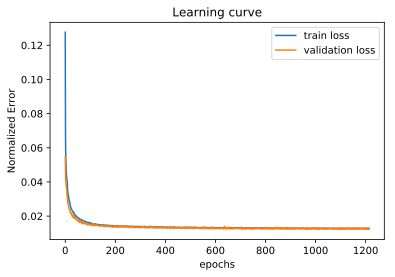

In [105]:
# Plotting the learning curve 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.plot(history.history['loss']/np.max(history.history['loss']))
# plt.plot(history.history['val_loss']/np.max(history.history['val_loss']))
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])


plt.title('Learning curve')
# plt.ylabel('Error/Accuracy')
plt.ylabel('Normalized Error')
plt.xlabel('epochs')
plt.legend(['train loss', 'validation loss'], loc='upper right')
# plt.savefig('/Figures/learning_curve_08Nov.png', bbox_inches='tight')

In [106]:
# Predict training and test data using the trained network
test_output_petro_norm = PetroModel.predict(X_test_petro)
train_output_petro_norm = PetroModel.predict(X_train_petro)

# Initialization
train_output_petro = np.zeros(train_output_petro_norm.shape)
test_output_petro = np.zeros(test_output_petro_norm.shape)
Y_train_petro = np.zeros(Y_train_petro_norm.shape)
Y_test_petro = np.zeros(Y_test_petro_norm.shape)

# Back transforming porosity to unnormalized values 
train_output_petro[:,0,:] = train_output_petro_norm[:,0,:]*(np.max(porosity) - np.min(porosity)) + np.min(porosity)
test_output_petro[:,0,:] = test_output_petro_norm[:,0,:]*(np.max(porosity) - np.min(porosity)) + np.min(porosity)

# train_output_petro[:,0,:] = train_output_petro_norm[:,0,:]
# test_output_petro[:,0,:] = test_output_petro_norm[:,0,:]


# train_output_petro[:,0,:] = ((train_output_petro_norm[:,0,:].T)*(
#     (np.max(Y_train_petro[:,0,:], axis=1) - 
#      np.min(Y_train_petro[:,0,:], axis=1)) + 
#     np.min(Y_train_petro[:,0,:], axis=1))).T
# test_output_petro[:,0,:] = ((test_output_petro_norm[:,0,:].T)*(
#     (np.max(Y_test_petro[:,0,:], axis=1) - 
#      np.min(Y_test_petro[:,0,:], axis=1)) + 
#     np.min(Y_test_petro[:,0,:], axis=1))).T

train_output_petro[:,1,:] = train_output_petro_norm[:,1,:]
test_output_petro[:,1,:] = test_output_petro_norm[:,1,:]

# train_output_petro[:,1,:] = train_output_petro_norm[:,1,:]*(np.max(vclay) - np.min(vclay)) + np.min(vclay)
# test_output_petro[:,1,:] = test_output_petro_norm[:,1,:]*(np.max(vclay) - np.min(vclay)) + np.min(vclay)

Y_train_petro[:,0,:] = Y_train_petro_norm[:,0,:]*(np.max(porosity) - np.min(porosity)) + np.min(porosity)
Y_test_petro[:,0,:] = Y_test_petro_norm[:,0,:]*(np.max(porosity) - np.min(porosity)) + np.min(porosity)

# Y_train_petro[:,0,:] = Y_train_petro_norm[:,0,:]
# Y_test_petro[:,0,:] = Y_test_petro_norm[:,0,:]

# Y_train_petro[:,1,:] = Y_train_petro_norm[:,1,:]*(np.max(vclay) - np.min(vclay)) + np.min(vclay)
# Y_test_petro[:,1,:] = Y_test_petro_norm[:,1,:]*(np.max(vclay) - np.min(vclay)) + np.min(vclay)

Y_train_petro[:,1,:] = Y_train_petro_norm[:,1,:]
Y_test_petro[:,1,:] = Y_test_petro_norm[:,1,:]



In [29]:
# RMSE with respect to mean 
rmse_train = np.sqrt(np.mean(((train_output_petro - Y_train_petro)**2).mean(axis=2), axis = 0))/np.mean(np.mean(Y_train_petro, axis = 0), axis=1)
rmse_test = np.sqrt(np.mean(((test_output_petro - Y_test_petro)**2).mean(axis=2), axis = 0))/np.mean(np.mean(Y_test_petro, axis = 0), axis=1)

print("Training error = ", rmse_train)
print("Test error = ", rmse_test)

Training error =  [0.17052618 0.30260018]
Test error =  [0.19341821 0.3788528 ]


(0, 1)

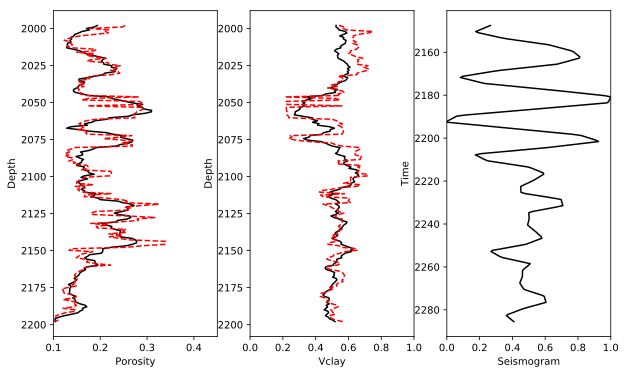

In [107]:
# Checking training data

sample_number = 400
f, axarr = plt.subplots(1, 3, sharey = False, figsize=(10,6))

axarr[0].plot(train_output_petro[sample_number, 0, :], depth, '-k')
axarr[0].plot(Y_train_petro[sample_number, 0, :], depth, '--r')
axarr[0].set_xlabel("Porosity")
axarr[0].set_ylabel("Depth")
axarr[0].invert_yaxis()
axarr[0].set_xlim(0.1,0.45)

axarr[1].plot(train_output_petro[sample_number, 1, :], depth, '-k')
axarr[1].plot(Y_train_petro[sample_number, 1, :], depth, '--r')
axarr[1].set_xlabel("Vclay")
axarr[1].set_ylabel("Depth")
axarr[1].invert_yaxis()
axarr[1].set_xlim(0,1)

# axarr[2].plot(train_output_petro[sample_number, 2, :], depth, '-k')
# axarr[2].plot(Y_train_petro[sample_number, 2, :], depth, '--r')
# axarr[2].set_xlabel("Sw")
# axarr[2].set_ylabel("Depth")
# axarr[2].invert_yaxis()
# axarr[2].set_xlim(0,1)

axarr[2].plot(X_train_petro[sample_number, 0, :,:], time_upscaled*1e3, '-k')
axarr[2].set_xlabel("Seismogram")
axarr[2].set_ylabel("Time")
axarr[2].invert_yaxis()
axarr[2].set_xlim(0,1)

(0, 1)

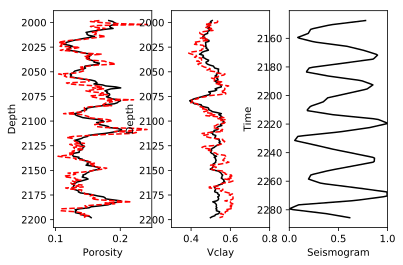

In [108]:
# Checking testing data

sample_number = 10
f, axarr = plt.subplots(1, 3, sharey = False)

axarr[0].plot(test_output_petro[sample_number, 0, :], depth, '-k')
axarr[0].plot(Y_test_petro[sample_number, 0, :], depth, '--r')
axarr[0].set_xlabel("Porosity")
axarr[0].set_ylabel("Depth")
axarr[0].invert_yaxis()
# axarr[0].set_xlim(1.5,3.1)

axarr[1].plot(test_output_petro[sample_number, 1, :], depth, '-k')
axarr[1].plot(Y_test_petro[sample_number, 1, :], depth, '--r')
axarr[1].set_xlabel("Vclay")
axarr[1].set_ylabel("Depth")
axarr[1].invert_yaxis()
axarr[1].set_xlim(0.3,0.8)

# axarr[2].plot(test_output_petro[sample_number, 2, :], depth, '-k')
# axarr[2].plot(Y_test_petro[sample_number, 2, :], depth, '--r')
# axarr[2].set_xlabel("Sw")
# axarr[2].set_ylabel("Depth")
# axarr[2].invert_yaxis()
# axarr[2].set_xlim(0,1)

# axarr[2].plot(test_output_petro_norm[sample_number, 0, :], depth, '-k')
# axarr[2].plot(Y_test_petro_norm[sample_number, 0, :], depth, '--r')
# axarr[2].set_xlabel("Norm_Poro")
# axarr[2].set_ylabel("Depth")
# axarr[2].invert_yaxis()
# # axarr[2].set_xlim(0,1)

axarr[2].plot(X_test_petro[sample_number, 0, :,:], time_upscaled*1e3, '-k')
axarr[2].set_xlabel("Seismogram")
axarr[2].set_ylabel("Time")
axarr[2].invert_yaxis()
axarr[2].set_xlim(0,1)

In [109]:
# Correlation coefficient between true and predicted traces 

Porosity_corr_train = np.zeros(train_output_petro.shape[0])
Vclay_corr_train = np.zeros(train_output_petro.shape[0])
# Sw_corr_train = np.zeros(train_output_petro.shape[0])
for i in range(train_output_petro.shape[0]):
    Porosity_corr_train[i] = np.corrcoef(train_output_petro[i,0,:], Y_train_petro[i,0,:])[0,1]
    Vclay_corr_train[i] = np.corrcoef(train_output_petro[i,1,:], Y_train_petro[i,1,:])[0,1]
#     Sw_corr_train[i] = np.corrcoef(train_output_petro[i,2,:], Y_train_petro[i,2,:])[0,1]
    
Porosity_corr_test = np.zeros(test_output_petro.shape[0])
Vclay_corr_test = np.zeros(test_output_petro.shape[0])
Sw_corr_test = np.zeros(test_output_petro.shape[0])
for i in range(test_output_petro.shape[0]):
    Porosity_corr_test[i] = np.corrcoef(test_output_petro[i,0,:], Y_test_petro[i,0,:])[0,1]
    Vclay_corr_test[i] = np.corrcoef(test_output_petro[i,1,:], Y_test_petro[i,1,:])[0,1]
#     Sw_corr_test[i] = np.corrcoef(test_output_petro[i,2,:], Y_test_petro[i,2,:])[0,1]

    
# Average correlation coefficient
print("Average correlation in porosity for training data = ", np.mean(Porosity_corr_train))
print("Average correlation in Vclay for training data = ", np.mean(Vclay_corr_train))
# print("Average correlation in Sw for training data = ", np.mean(Sw_corr_train))

print("Average correlation in porosity for test data = ", np.mean(Porosity_corr_test))
print("Average correlation in Vclay for test data = ", np.mean(Vclay_corr_test))
# print("Average correlation in Sw for test data = ", np.mean(Sw_corr_test))


Average correlation in porosity for training data =  0.8539375924059299
Average correlation in Vclay for training data =  0.7354109287242176
Average correlation in porosity for test data =  0.8162601436829378
Average correlation in Vclay for test data =  0.661303722892813


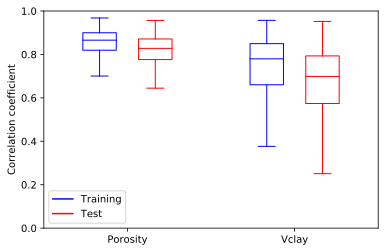

In [110]:
# Box plot of correlation coefficients 

from pylab import plot, show, savefig, xlim, figure, \
                hold, ylim, legend, boxplot, setp, axes

# function for setting the colors of the box plots pairs
def setBoxColors(bp):
    setp(bp['boxes'][0], color='blue')
    setp(bp['caps'][0], color='blue')
    setp(bp['caps'][1], color='blue')
    setp(bp['whiskers'][0], color='blue')
    setp(bp['whiskers'][1], color='blue')
#     setp(bp['fliers'][0], color='blue')
#     setp(bp['fliers'][1], color='blue')
    setp(bp['medians'][0], color='blue')

    setp(bp['boxes'][1], color='red')
    setp(bp['caps'][2], color='red')
    setp(bp['caps'][3], color='red')
    setp(bp['whiskers'][2], color='red')
    setp(bp['whiskers'][3], color='red')
#     setp(bp['fliers'][2], color='red')
#     setp(bp['fliers'][3], color='red')
    setp(bp['medians'][1], color='red')

# Some fake data to plot
A= [Porosity_corr_train, Porosity_corr_test]
B = [Vclay_corr_train, Vclay_corr_test]
# C = [Sw_corr_train, Sw_corr_test]

fig = figure()
ax = axes()

# first boxplot pair
bp = boxplot(A, positions = [1, 2], widths = 0.6, showfliers=False)
setBoxColors(bp)

# second boxplot pair
bp = boxplot(B, positions = [4, 5], widths = 0.6, showfliers=False)
setBoxColors(bp)

# thrid boxplot pair
# bp = boxplot(C, positions = [7, 8], widths = 0.6, showfliers=False)
# setBoxColors(bp)

# set axes limits and labels
# xlim(0,9)
xlim(0,6)
ylim(0,1)
# ax.set_xticklabels(['Porosity', 'Vclay', 'Sw'])
ax.set_xticklabels(['Porosity', 'Vclay'])
# ax.set_xticks([1.5, 4.5, 7.5])
ax.set_xticks([1.5, 4.5])
plt.ylabel('Correlation coefficient')

# draw temporary red and blue lines and use them to create a legend
hB, = plot([1,1],'b-')
hR, = plot([1,1],'r-')
legend((hB, hR),('Training', 'Test'), loc='lower left')
hB.set_visible(False)
hR.set_visible(False)

In [ ]:
# Histogram plot for true vs predicted values
for i in np.arange(0,train_output_petro.shape[0],100):
    plt.hist(Y_train_petro[i,0,:], histtype='step', color='black')
    plt.hist(train_output_petro[i,0,:], histtype='step', color='red')
    plt.xlabel('Porosity')
    plt.ylabel('Frequency')
    plt.title('Training examples')



In [ ]:
# Histogram plot for true vs predicted values
for i in np.arange(0,train_output_petro.shape[0],100):
    plt.hist(Y_train_petro[i,1,:], histtype='step', color='black')
    plt.hist(train_output_petro[i,1,:], histtype='step', color='red')
    plt.xlabel('Vclay')
    plt.ylabel('Frequency')
    plt.title('Training examples')

In [ ]:
# Histogram plot for true vs predicted values
for i in np.arange(0,train_output_petro.shape[0],100):
    plt.hist(Y_train_petro[i,2,:], histtype='step', color='black')
    plt.hist(train_output_petro[i,2,:], histtype='step', color='red')
    plt.xlabel('Sw')
    plt.ylabel('Frequency')
    plt.title('Training examples')

In [ ]:
for i in range(test_output_petro.shape[0]):
    plt.hist(Y_test_petro[i,0,:], histtype='step', color='black')
    plt.hist(test_output_petro[i,0,:], histtype='step', color='red')
    plt.xlabel('Porosity')
    plt.ylabel('Frequency')
    plt.title('Test examples')

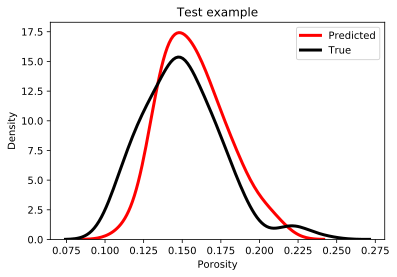

In [101]:
# Density estimate for true vs predicted (test example) Porosity

import seaborn as sns

sample_number = 10
sns.kdeplot(test_output_petro[sample_number,0,:],  
             color='red', label='Predicted', linewidth=3,
            bw=0.01,
             clip=(np.min(test_output_petro[sample_number,0,:]), np.max(test_output_petro[sample_number,0,:])))
sns.kdeplot(Y_test_petro[sample_number,0,:],  
             color='black', label='True', linewidth=3,
            bw=0.01,
             clip=(np.min(Y_test_petro[sample_number,0,:]), np.max(Y_test_petro[sample_number,0,:])))
plt.xlabel('Porosity')
plt.ylabel('Density')
plt.title('Test example')
plt.legend()

(-0.1, 1.1)

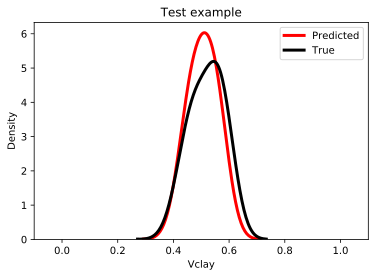

In [102]:
# Density estimate for true vs predicted (test example) Vclay

sample_number = 10

sns.kdeplot(test_output_petro[sample_number,1,:],  
             color='red', label='Predicted', linewidth=3,
             bw=0.04,
           clip=(np.min(test_output_petro[sample_number,1,:]), np.max(test_output_petro[sample_number,1,:])))
sns.kdeplot(Y_test_petro[sample_number,1,:],  
             color='black', label='True', linewidth=3,
            bw=0.04,
             clip=(np.min(Y_test_petro[sample_number,1,:]), np.max(Y_test_petro[sample_number,1,:])))
plt.xlabel('Vclay')
plt.ylabel('Density')
plt.title('Test example')
plt.legend()
plt.xlim(-0.1,1.1)

In [ ]:
# Density estimate for true vs predicted (test example) Water saturation 

sample_number = 12

sns.kdeplot(test_output_petro[sample_number,2,:],  
             color='red', label='Predicted', linewidth=3,
             bw=0.04,
           clip=(np.min(test_output_petro[sample_number,2,:]), np.max(test_output_petro[sample_number,2,:])))
sns.kdeplot(Y_test_petro[sample_number,2,:],  
             color='black', label='True', linewidth=3,
            bw=0.04,
             clip=(np.min(Y_test_petro[sample_number,2,:]), np.max(Y_test_petro[sample_number,2,:])))
plt.xlabel('Sw')
plt.ylabel('Density')
plt.title('Test example')
plt.legend()
plt.xlim(-0.1,1.1)

In [ ]:
for i in range(test_output_petro.shape[0]):
    plt.hist(Y_test_petro[i,1,:], histtype='step', color='black')
    plt.hist(test_output_petro[i,1,:], histtype='step', color='red')
    plt.xlabel('Vclay')
    plt.ylabel('Frequency')
    plt.title('Test examples')

In [ ]:
for i in range(test_output_petro.shape[0]):
    plt.hist(Y_test_petro[i,2,:], histtype='step', color='black')
    plt.hist(test_output_petro[i,2,:], histtype='step', color='red')
    plt.xlabel('Sw')
    plt.ylabel('Frequency')
    plt.title('Test examples')

In [ ]:
# Compute variograms for true and predicted data

from gstools import vario_estimate_unstructured, Spherical
from gstools.covmodel.plot import plot_variogram

# estimate the variogram of the field with 40 bins
bins = np.arange(50)

sample_number = 25
bin_center, gamma = vario_estimate_unstructured(depth.T, Y_train_petro[sample_number,0,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="black")
plt.xlabel('Distance/ Lag')
plt.ylabel('Normalized semi-variance')
plt.title('Training dataset (Porosity)')
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])
    
bin_center, gamma = vario_estimate_unstructured(depth.T, train_output_petro[sample_number,0,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="red")
plt.gca().legend(('True','Predicted'))
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])

In [ ]:
# Compute variograms for true and predicted data

from gstools import vario_estimate_unstructured, Spherical
from gstools.covmodel.plot import plot_variogram

# estimate the variogram of the field with 40 bins
bins = np.arange(50)

sample_number = 25
bin_center, gamma = vario_estimate_unstructured(depth.T, Y_train_petro[sample_number,1,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="black")
plt.xlabel('Distance/ Lag')
plt.ylabel('Normalized semi-variance')
plt.title('Training dataset (Vclay)')
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])
    
bin_center, gamma = vario_estimate_unstructured(depth.T, train_output_petro[sample_number,1,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="red")
plt.gca().legend(('True','Predicted'))
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])

In [ ]:
# Compute variograms for true and predicted data

from gstools import vario_estimate_unstructured, Spherical
from gstools.covmodel.plot import plot_variogram

# estimate the variogram of the field with 40 bins
bins = np.arange(50)

sample_number = 25
bin_center, gamma = vario_estimate_unstructured(depth.T, Y_train_petro[sample_number,2,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="black")
plt.xlabel('Distance/ Lag')
plt.ylabel('Normalized semi-variance')
plt.title('Training dataset (Sw)')
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])
    
bin_center, gamma = vario_estimate_unstructured(depth.T, train_output_petro[sample_number,2,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="red")
plt.gca().legend(('True','Predicted'))
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])

In [30]:
# Compute variograms for true and predicted data

from gstools import vario_estimate_unstructured, Spherical
from gstools.covmodel.plot import plot_variogram

# estimate the variogram of the field with 40 bins
bins = np.arange(50)

sample_number = 12
bin_center, gamma = vario_estimate_unstructured(depth.T, Y_test_petro[sample_number,0,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="black")
plt.xlabel('Distance/ Lag')
plt.ylabel('Normalized semi-variance')
plt.title('Test dataset (Porosity)')
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])
    
bin_center, gamma = vario_estimate_unstructured(depth.T, test_output_petro[sample_number,0,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="red")
plt.gca().legend(('True','Predicted'))
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])

ValueError: len(x) = 1 != len(f) = 200 

({'var': 0.05575099290761263,
  'len_scale': 21.903715073577796,
  'nugget': 1.5727464628216449e-34},
 array([[ 3.28844016e-05, -6.56322911e-03, -3.01769368e-05],
        [-6.56322911e-03,  8.08105072e+00,  8.91468225e-03],
        [-3.01769368e-05,  8.91468225e-03,  3.10537896e-05]]))

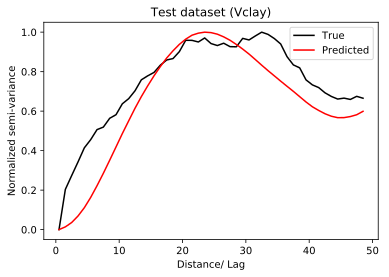

In [30]:
# Compute variograms for true and predicted data

from gstools import vario_estimate_unstructured, Spherical
from gstools.covmodel.plot import plot_variogram

# estimate the variogram of the field with 40 bins
bins = np.arange(50)

sample_number = 12
bin_center, gamma = vario_estimate_unstructured(depth.T, Y_test_petro[sample_number,1,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="black")
plt.xlabel('Distance/ Lag')
plt.ylabel('Normalized semi-variance')
plt.title('Test dataset (Vclay)')
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])
    
bin_center, gamma = vario_estimate_unstructured(depth.T, test_output_petro[sample_number,1,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="red")
plt.gca().legend(('True','Predicted'))
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])

In [ ]:
# Compute variograms for true and predicted data

from gstools import vario_estimate_unstructured, Spherical
from gstools.covmodel.plot import plot_variogram

# estimate the variogram of the field with 40 bins
bins = np.arange(50)

sample_number = 12
bin_center, gamma = vario_estimate_unstructured(depth.T, Y_test_petro[sample_number,1,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="black")
plt.xlabel('Distance/ Lag')
plt.ylabel('Normalized semi-variance')
plt.title('Test dataset (Sw)')
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])
    
bin_center, gamma = vario_estimate_unstructured(depth.T, test_output_petro[sample_number,1,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="red")
plt.gca().legend(('True','Predicted'))
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])

In [ ]:
# Spectral coherence between true and predicted 

sample_number = 25
plt.cohere(Y_train_petro[sample_number,0,:], train_output_petro[sample_number,0,:], NFFT=16, Fs=1, color="blue")
plt.cohere(Y_train_petro[sample_number,1,:], train_output_petro[sample_number,1,:], NFFT=16, Fs=1, color="red") 
# plt.cohere(Y_train_petro[sample_number,2,:], train_output_petro[sample_number,2,:], NFFT=16, Fs=1, color="black")


# plt.gca().legend(('Porosity','Vclay', 'Sw'))
plt.gca().legend(('Porosity','Vclay'))
plt.xlabel('Wavenumber')
plt.ylabel('Coherence')
plt.title('Training example')
plt.grid(b=False)

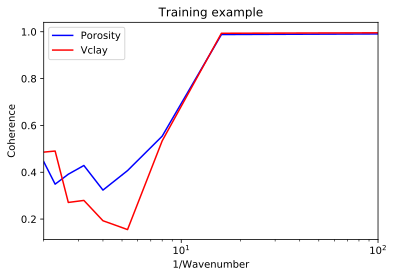

In [103]:
# Spectral coherence between true and predicted (training data)

sample_number = 400
Cxy_poro, wavenumber_poro = plt.cohere(Y_train_petro[sample_number,0,:], train_output_petro[sample_number,0,:], NFFT=16, Fs=1, color="blue")
Cxy_vclay, wavenumber_vclay = plt.cohere(Y_train_petro[sample_number,1,:], train_output_petro[sample_number,1,:], NFFT=16, Fs=1, color="red") 
# Cxy_sw, wavenumber_sw = plt.cohere(Y_test_petro[sample_number,2,:], test_output_petro[sample_number,2,:], NFFT=16, Fs=1, color="black")

# Adding epsilon to the first wavenumber value
wavenumber_poro[0] = wavenumber_poro[0] + 0.001
wavenumber_vclay[0] = wavenumber_vclay[0] + 0.001
# wavenumber_sw[0] = wavenumber_sw[0] + 0.001

plt.plot(1/wavenumber_poro, Cxy_poro, color="blue")
plt.plot(1/wavenumber_vclay, Cxy_vclay, color="red")
# plt.plot(1/wavenumber_sw, Cxy_sw, color="black")

plt.xlim(100,2)
plt.gca().invert_xaxis()
plt.xscale("log")

# plt.gca().legend(('Porosity','Vclay', 'Sw'))
plt.gca().legend(('Porosity','Vclay'))
plt.xlabel('1/Wavenumber')
plt.ylabel('Coherence')
plt.title('Training example')
plt.grid(b=False)

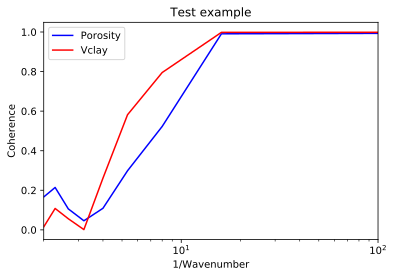

In [104]:
# Spectral coherence between true and predicted (test data)

sample_number = 10
Cxy_poro, wavenumber_poro = plt.cohere(Y_test_petro[sample_number,0,:], test_output_petro[sample_number,0,:], NFFT=16, Fs=1, color="blue")
Cxy_vclay, wavenumber_vclay = plt.cohere(Y_test_petro[sample_number,1,:], test_output_petro[sample_number,1,:], NFFT=16, Fs=1, color="red") 
# Cxy_sw, wavenumber_sw = plt.cohere(Y_test_petro[sample_number,2,:], test_output_petro[sample_number,2,:], NFFT=16, Fs=1, color="black")

# Adding epsilon to the first wavenumber value
wavenumber_poro[0] = wavenumber_poro[0] + 0.001
wavenumber_vclay[0] = wavenumber_vclay[0] + 0.001
# wavenumber_sw[0] = wavenumber_sw[0] + 0.001

plt.plot(1/wavenumber_poro, Cxy_poro, color="blue")
plt.plot(1/wavenumber_vclay, Cxy_vclay, color="red")
# plt.plot(1/wavenumber_sw, Cxy_sw, color="black")

plt.xlim(100,2)
plt.gca().invert_xaxis()
plt.xscale("log")

# plt.gca().legend(('Porosity','Vclay', 'Sw'))
plt.gca().legend(('Porosity','Vclay'))
plt.xlabel('1/Wavenumber')
plt.ylabel('Coherence')
plt.title('Test example')
plt.grid(b=False)

Text(0,0.5,'Depth')

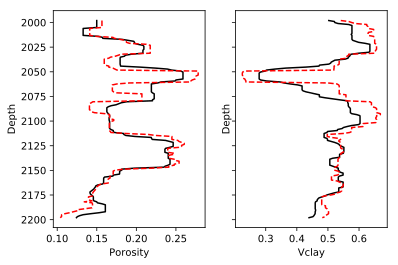

In [105]:



# Checking training data (smoothed)

sample_number = 400
f, axarr = plt.subplots(1, 2, sharey = True)

ker_width = 15

axarr[0].plot(sp.medfilt(train_output_petro[sample_number, 0, :],ker_width), depth, '-k')
axarr[0].plot(sp.medfilt(Y_train_petro[sample_number, 0, :], ker_width), depth, '--r')
axarr[0].set_xlabel("Porosity")
axarr[0].set_ylabel("Depth")
axarr[0].invert_yaxis()
# axarr[0].set_xlim(1.5,3.1)

axarr[1].plot(sp.medfilt(train_output_petro[sample_number, 1, :], ker_width), depth, '-k')
axarr[1].plot(sp.medfilt(Y_train_petro[sample_number, 1, :],ker_width), depth, '--r')
axarr[1].set_xlabel("Vclay")
axarr[1].set_ylabel("Depth")
# axarr[1].invert_yaxis()
# axarr[1].set_xlim(1,2)

In [106]:
por_corr_coeff_smooth_train = np.corrcoef(sp.medfilt(train_output_petro[sample_number, 0, :],ker_width),
                                                     sp.medfilt(Y_train_petro[sample_number, 0, :], ker_width))
                                          
vclay_corr_coeff_smooth_train = np.corrcoef(sp.medfilt(train_output_petro[sample_number, 1, :],ker_width),
                                                     sp.medfilt(Y_train_petro[sample_number, 1, :], ker_width))

print("Correlation coefficient between smoothed true and predicted porosity for training example = ", 
     '%.3f'%(por_corr_coeff_smooth_train[0,1]))
print("Correlation coefficient between smoothed true and predicted vclay for training example = ", 
     '%.3f'%(vclay_corr_coeff_smooth_train[0,1]))

Correlation coefficient between smoothed true and predicted porosity for training example =  0.899
Correlation coefficient between smoothed true and predicted vclay for training example =  0.881


Text(0,0.5,'Depth')

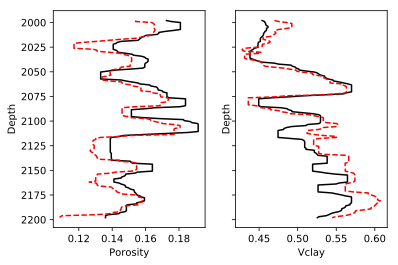

In [109]:
# Checking testing data (smoothed)

sample_number = 10
f, axarr = plt.subplots(1, 2, sharey = True)

ker_width = 15

axarr[0].plot(sp.medfilt(test_output_petro[sample_number, 0, :],ker_width), depth, '-k')
axarr[0].plot(sp.medfilt(Y_test_petro[sample_number, 0, :], ker_width), depth, '--r')
axarr[0].set_xlabel("Porosity")
axarr[0].set_ylabel("Depth")
axarr[0].invert_yaxis()
# axarr[0].set_xlim(0.15,0.45)

axarr[1].plot(sp.medfilt(test_output_petro[sample_number, 1, :],ker_width), depth, '-k')
axarr[1].plot(sp.medfilt(Y_test_petro[sample_number, 1, :],ker_width), depth, '--r')
axarr[1].set_xlabel("Vclay")
axarr[1].set_ylabel("Depth")
# axarr[1].invert_yaxis()
# axarr[1].set_xlim(0,1)

In [110]:
por_corr_coeff_smooth_test = np.corrcoef(sp.medfilt(test_output_petro[sample_number, 0, :],ker_width),
                                                     sp.medfilt(Y_test_petro[sample_number, 0, :], ker_width))
                                          
vclay_corr_coeff_smooth_test = np.corrcoef(sp.medfilt(test_output_petro[sample_number, 1, :],ker_width),
                                                     sp.medfilt(Y_test_petro[sample_number, 1, :], ker_width))

print("Correlation coefficient between smoothed true and predicted porosity for test example = ", 
     '%.3f'%(por_corr_coeff_smooth_test[0,1]))
print("Correlation coefficient between smoothed true and predicted vclay for test example = ", 
     '%.3f'%(vclay_corr_coeff_smooth_test[0,1]))

Correlation coefficient between smoothed true and predicted porosity for test example =  0.900
Correlation coefficient between smoothed true and predicted vclay for test example =  0.908


## Test using Sty1 data

In [111]:
sty1_logs_in_depth = np.loadtxt('../../../Data_Stybarrow_field/sty1_logs_in_depth_for_test.txt')
sty1_depth = sty1_logs_in_depth[:,0]
sty1_vsh = sty1_logs_in_depth[:,1]
sty1_poro = sty1_logs_in_depth[:,2]

sty1_logs_in_time = np.loadtxt('../../../Data_Stybarrow_field/sty1_logs_in_time_for_test.txt')
sty1_time = sty1_logs_in_time[:,0]
sty1_nearstack = sty1_logs_in_time[:,1]
sty1_farstack = sty1_logs_in_time[:,2]

In [112]:
sty1_depth_block = np.linspace(np.min(sty1_depth), np.max(sty1_depth), 200)
sty1_vsh_block = np.interp(sty1_depth_block, sty1_depth, sty1_vsh)
sty1_poro_block = np.interp(sty1_depth_block, sty1_depth, sty1_poro)


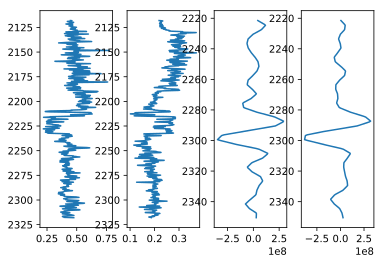

In [113]:
plt.subplot(1,4,1)
plt.plot(sty1_vsh, sty1_depth)
plt.gca().invert_yaxis()
plt.subplot(1,4,2)
plt.plot(sty1_poro, sty1_depth)
plt.gca().invert_yaxis()
plt.subplot(1,4,3)
plt.plot(sty1_nearstack, sty1_time)
plt.gca().invert_yaxis()
plt.subplot(1,4,4)
plt.plot(sty1_farstack, sty1_time)
plt.gca().invert_yaxis()

In [114]:
# Preparing data for input to network

sty1_nearstack_normalized = (sty1_nearstack - np.min(sty1_nearstack))/(np.max(sty1_nearstack)-np.min(sty1_nearstack))
sty1_farstack_normalized = (sty1_farstack - np.min(sty1_farstack))/(np.max(sty1_farstack)-np.min(sty1_farstack))

angle_seis_sty1_normalized = np.expand_dims(np.swapaxes(np.expand_dims(
    np.c_[sty1_nearstack_normalized, sty1_farstack_normalized], axis=0),1,2),axis=-1)



In [115]:
output_sty1_norm = PetroModel.predict(angle_seis_sty1_normalized)
output_sty1 = output_sty1_norm
output_sty1[:,0,:] = output_sty1_norm[:,0,:]*(np.max(porosity) - np.min(porosity)) + np.min(porosity)
# output_sty1[:,1,:] = output_sty1_norm[:,1,:]*(np.max(vclay) - np.min(vclay)) + np.min(vclay)
# output_sty1[:,0,:] = output_sty1_norm[:,0,:]
output_sty1[:,1,:] = output_sty1_norm[:,1,:]

(0, 1)

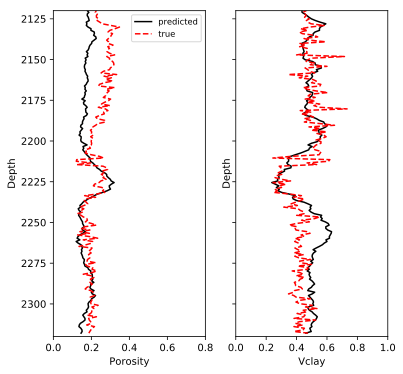

In [116]:
# Plotting network output with true outputs

sample_number = 0
f, axarr = plt.subplots(1, 2, sharey = True, figsize=(6,6))

ker_width = 1

sty1_poro_block_norm = (sty1_poro_block - np.min(sty1_poro_block))/(np.max(sty1_poro_block) - np.min(sty1_poro_block))

axarr[0].plot(output_sty1[sample_number, 0, :], sty1_depth_block, '-k', label='predicted')
# axarr[0].plot(sty1_poro_block, sty1_depth_block, '--r', label='true')
axarr[0].plot(sp.medfilt(sty1_poro_block,ker_width), sty1_depth_block, '--r', label='true')
# axarr[0].plot(sp.medfilt(well3_poro_block,ker_width), depth_new, '--g', label='median-filtered')
axarr[0].set_xlabel("Porosity")
axarr[0].set_ylabel("Depth")
axarr[0].legend(loc="upper right", fontsize='small')
axarr[0].invert_yaxis()
axarr[0].set_ylim(2120,2320)
axarr[0].set_xlim(0,0.8)

axarr[1].plot(output_sty1[sample_number, 1, :], sty1_depth_block, '-k')
# axarr[1].plot(sty1_vsh, sty1_depth, '--r')
axarr[1].plot(sp.medfilt(sty1_vsh_block,ker_width), sty1_depth_block, '--r')
axarr[1].set_xlabel("Vclay")
axarr[1].set_ylabel("Depth")
axarr[1].invert_yaxis()
axarr[1].set_xlim(0,1)


In [65]:
np.corrcoef(output_sty1[sample_number, 1, :], sty1_vsh_block)

array([[1.        , 0.44227076],
       [0.44227076, 1.        ]])

## Test with Sty2

In [42]:
sty2_logs_in_depth = np.loadtxt('../../../Data_Stybarrow_field/sty2_logs_in_depth_for_test.txt')
sty2_depth = sty2_logs_in_depth[:,0]
sty2_vsh = sty2_logs_in_depth[:,1]
sty2_poro = sty2_logs_in_depth[:,2]

sty2_logs_in_time = np.loadtxt('../../../Data_Stybarrow_field/sty2_logs_in_time_for_test.txt')
sty2_time = sty2_logs_in_time[:,0]
sty2_nearstack = sty2_logs_in_time[:,1]
sty2_farstack = sty2_logs_in_time[:,2]


In [43]:
sty2_depth_block = np.linspace(np.min(sty2_depth), np.max(sty2_depth), 200)
sty2_vsh_block = np.interp(sty2_depth_block, sty2_depth, sty2_vsh)
sty2_poro_block = np.interp(sty2_depth_block, sty2_depth, sty2_poro)


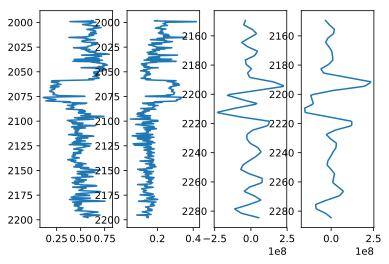

In [44]:
plt.subplot(1,4,1)
plt.plot(sty2_vsh, sty2_depth)
plt.gca().invert_yaxis()
plt.subplot(1,4,2)
plt.plot(sty2_poro, sty2_depth)
plt.gca().invert_yaxis()
plt.subplot(1,4,3)
plt.plot(sty2_nearstack, sty2_time)
plt.gca().invert_yaxis()
plt.subplot(1,4,4)
plt.plot(sty2_farstack, sty2_time)
plt.gca().invert_yaxis()


In [117]:
# Preparing data for input to network

sty2_nearstack_normalized = (sty2_nearstack - np.min(sty2_nearstack))/(np.max(sty2_nearstack)-np.min(sty2_nearstack))
sty2_farstack_normalized = (sty2_farstack - np.min(sty2_farstack))/(np.max(sty2_farstack)-np.min(sty2_farstack))

angle_seis_sty2_normalized = np.expand_dims(np.swapaxes(np.expand_dims(
    np.c_[sty2_nearstack_normalized, sty2_farstack_normalized], axis=0),1,2),axis=-1)



In [118]:
output_sty2_norm = PetroModel.predict(angle_seis_sty2_normalized)
output_sty2 = output_sty2_norm
output_sty2[:,0,:] = output_sty2_norm[:,0,:]*(np.max(porosity) - np.min(porosity)) + np.min(porosity)
# output_sty2[:,1,:] = output_sty2_norm[:,1,:]*(np.max(vclay) - np.min(vclay)) + np.min(vclay)
# output_sty2[:,0,:] = output_sty2_norm[:,0,:]
output_sty2[:,1,:] = output_sty2_norm[:,1,:]

(0, 1)

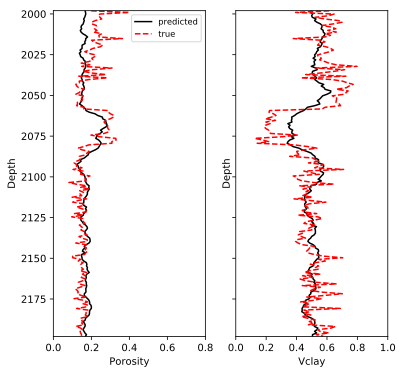

In [119]:
# Plotting network output with true outputs

sample_number = 0
f, axarr = plt.subplots(1, 2, sharey = True, figsize=(6,6))

ker_width = 1

axarr[0].plot(output_sty2[sample_number, 0, :], sty2_depth_block, '-k', label='predicted')
# axarr[0].plot(sty2_poro, sty2_depth, '--r', label='true')
axarr[0].plot(sp.medfilt(sty2_poro_block,ker_width), sty2_depth_block, '--r', label='true')
axarr[0].set_xlabel("Porosity")
axarr[0].set_ylabel("Depth")
axarr[0].legend(loc="upper right", fontsize='small')
axarr[0].set_ylim(1998,2198)
axarr[0].set_xlim(0,0.8)
axarr[0].invert_yaxis()

axarr[1].plot(output_sty2[sample_number, 1, :], sty2_depth_block, '-k')
# axarr[1].plot(sty2_vsh, sty2_depth, '--r')
axarr[1].plot(sp.medfilt(sty2_vsh_block,ker_width), sty2_depth_block, '--r')
axarr[1].set_xlabel("Vclay")
axarr[1].set_ylabel("Depth")
# axarr[1].invert_yaxis()
axarr[1].set_xlim(0,1)


